In [27]:
import pandas as pd
import numpy as np

%matplotlib inline
import pylab as plt
plt.style.use('fivethirtyeight')

# Read data

In [51]:
data = pd.read_csv('./data/EF_battles_corrected.csv', parse_dates=['start', 'end'])

In [52]:
data.shape

(133, 29)

In [54]:
data['end_num'] = (data['end'].dt.year -1938) * 12 +  data['end'].dt.month
data['start_num'] = (data['start'].dt.year -1938) * 12 +  data['start'].dt.month
data['duration'] = (data['end_num'] - data['start_num']).clip(lower=1)

In [55]:
data.shape

(133, 32)

### Data types and missing values

In [56]:
data.dtypes

name                                 object
url                                  object
allies killed                       float64
axis killed                         float64
allies_destroyed_tanks                int64
allies_destroyed_airplane             int64
allies_destroyed_guns                 int64
axis_destroyed_tanks                  int64
axis_destroyed_airplane               int64
axis_destroyed_guns                   int64
belligerents.allies                  object
belligerents.axis                    object
axis_leaders                         object
allies_leaders                       object
result_prop                         float64
result                               object
axis_planes                         float64
axis_guns                           float64
axis_tanks                          float64
axis_infantry                       float64
allies_planes                       float64
allies_guns                         float64
allies_tanks                    

In [57]:
cols = [
    'allies_infantry', 'axis_infantry',
    'allies_tanks', 'axis_tanks',
    'allies_guns', 'axis_guns'
]


In [58]:
mask = data[cols].notnull().all(1)

In [59]:
data_kmeans = data.loc[mask, cols]

In [66]:
data_kmeans.shape

(19, 10)

In [68]:
data['result_num'] = data['result'].map({'axis':-1, 'allies':1}).fillna(0)  # 0 for tie

In [69]:
data['result_num'].value_counts()

-1.0    93
 1.0    34
 0.0     6
Name: result_num, dtype: int64

# 1. Unsupervised learning: K-means

In [60]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=5)

In [61]:
labels = model.fit_predict(data_kmeans) + 1  # for naming

In [62]:
print(labels + 1)

[5 4 5 2 4 6 3 5 3 3 5 5 6 5 4 3 5 3 4]


In [63]:
data_kmeans['label'] = ('Cluster ' + pd.Series((labels+1)).astype(str)).values
data_kmeans[['name', 'result', 'start']] = data.loc[mask, ['name', 'result', 'start']]

## Visualise

In [64]:
import altair as alt


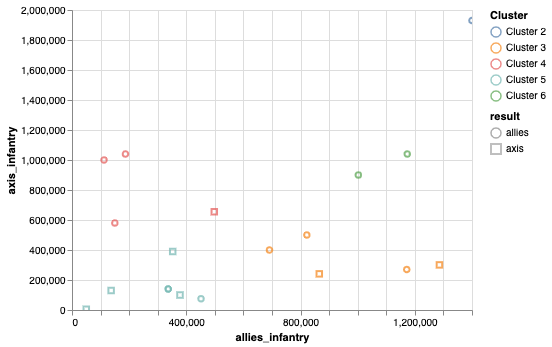

In [65]:
c = alt.Chart(data_kmeans).mark_point().encode(
    color=alt.Color('label:N', legend=alt.Legend(title='Cluster')),
    x='allies_infantry', y='axis_infantry', shape='result',
    tooltip=data_kmeans.columns.tolist()).interactive()

c

# Scale

In [84]:
from sklearn.preprocessing import scale

In [85]:
data_scaled = scale(data_kmeans.drop(['label', 'name', 'start', 'result'], axis=1))

In [86]:
labels_scaled = model.fit_predict(data_scaled) + 1

In [87]:
# data_scaled['label'] = ('Cluster ' + pd.Series((labels_scaled +1)).astype(str)).values
# data_scaled[['name', 'result', 'start']] = data.loc[~mask, ['name', 'result', 'start']]

data_kmeans['label 2'] = ('Cluster ' + pd.Series((labels_scaled +1)).astype(str)).values

In [88]:
c.data = data_kmeans

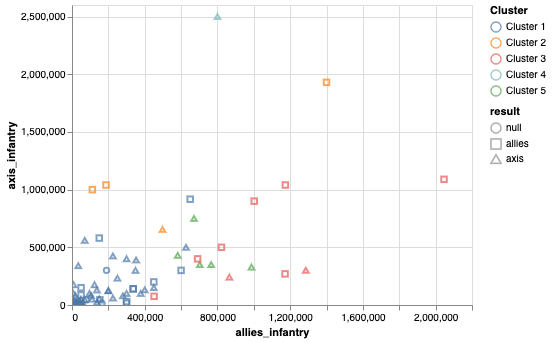

In [89]:
c.encode(color=alt.Color('label 2:N', legend=alt.Legend(title='Cluster')))

In [ ]:
data